## Integrating a simple harmonic oscillator and trying to fit for the spring constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline

In [2]:
def leapfrog(x0, v0, t_obs, phi_grad, dt, nsteps, *args, **kwargs):
    #function that takes initial conditions that takes us to the next position 
    v0_5 = v0 + phi_grad(x0, *args, **kwargs)*dt/2.
    x = [] 
    v = [] 
    t = [] 

    tprime = 0.0
    xprime = x0
    vprime = v0
    
    for to in t_obs:
        while tprime + dt < to:
            xprime = xprime + dt*v0_5
            a      = -phi_grad(xprime, *args, **kwargs)
            vprime = (v0_5 + a*dt/2)
            v0_5   = v0_5 + a*dt
            tprime = tprime + dt        
        dt_tiny = to - tprime
        xprime = xprime + dt_tiny*v0_5
        a      = -phi_grad(xprime, *args, **kwargs)
        vprime = (v0_5 + a*dt_tiny/2)
        v0_5   = v0_5 + a*dt_tiny
        tprime = tprime + dt_tiny
        
        x.append(xprime)
        v.append(vprime)
        t.append(tprime)

    return np.array(x), np.array(v), np.array(t)

In [3]:
def phi_grad(x, k=1):
    return k*x

In [4]:
def genData(x, v, npoints, std_noise):
    noise_x = np.random.normal(0, std_noise, len(x))
    noise_v = np.random.normal(0, std_noise, len(x))
    return noise_x + x, noise_v + v

In [5]:
def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0 = theta
    x_obs, v_obs, t_obs, sigma_x, sigma_v = data
    nsteps_model = int(np.max(t_obs)/dt_model) + 10 #hack, add 10 for cusion 
    x, v, t = leapfrog(x0, v0, t_obs, phi_grad, dt_model, nsteps_model, k=k)
    #interpolate between values and sample at observed t
    #order = 3
    #v_interp = InterpolatedUnivariateSpline(t, v, k=order)
    #x_interp = InterpolatedUnivariateSpline(t, x, k=order)

    #close_ind = []
    #for to in t_obs:
    #    dt = np.abs(t - to)
    #    close_ind.append(np.where(dt == np.min(dt))[0])
    #close_ind = np.array(close_ind).T
    #print(close_ind)
    #plt.plot(t, v_interp(t), c='C0')
    #plt.plot(t_true, v_true, c='black')
    #plt.plot(t, x_interp(t), c='C1')
    #plt.plot(t_true, x_true, c='black')
    #print(v[close_ind], v_obs, x[close_ind], x_obs)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

In [6]:
x0_true   = 0
v0_true   = 100
k_true    = 10

dt        = 0.1
dt_model  = 0.1 #rate to sample the likelihood model to interpolate to t_obs
nmodelpoints = 30

nobspoints   = 10
std_noise = 1.0

t_obs = np.random.uniform(0, dt*nmodelpoints, nobspoints)
t_obs.sort()

assert nmodelpoints > nobspoints, 'The number of model points must be greater than the number of observed points'

In [7]:
t_obs

array([ 0.01474889,  0.07393235,  0.44208938,  0.85453608,  0.99891407,
        1.53840346,  1.60947163,  1.75087224,  2.78877762,  2.84670806])

In [8]:
#generate true values and noisify them
x_true, v_true, t_true = leapfrog(x0_true, v0_true, t_obs, phi_grad, dt, nmodelpoints, k=k_true)
x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise)

In [13]:
assert np.allclose(t_true, t_obs), 'Observed times and integrated times are not the same'

In [14]:
data   = [x_obs, v_obs, t_obs, std_noise, std_noise]
p_true = [k_true, x0_true, v0_true]
p0     = [k_true*1.1, x0_true*1.1, v0_true*1.1]
args   = (data, dt_model)

<Container object of 3 artists>

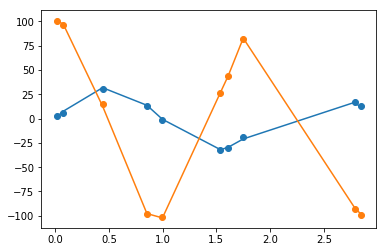

In [15]:
plt.plot(t_true, x_true, c='C0')
plt.plot(t_true, v_true, c='C1')
plt.errorbar(t_obs, x_obs, yerr=std_noise, fmt='o', color='C0')
plt.errorbar(t_obs, v_obs, yerr=std_noise, fmt='o', color='C1')

In [16]:
ln_likelihood(p0, data, dt_model)

-1991.8966045240245

In [17]:
#%%timeit
#res = so.minimize(lambda *args : -ln_likelihood(*args),
#                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [18]:
res = so.minimize(lambda *args : -ln_likelihood(*args),
                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [19]:
res

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.06529474, -0.02360153, -0.54298218],
       [-0.03405832,  0.30726486, -0.29451522]])
     fun: 11.778028381285695
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 5
  status: 0
 success: True
       x: array([  10.03924362,   -0.3080085 ,  100.01001921])

In [20]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(res.x[0], res.x[1], res.x[2]))


The true values are: k = 10.00, x0 = 0.00, v0 = 100.00
The optimized values are: k = 10.04, x0 = -0.31, v0 = 100.01


Text(0.5,1,'Best fit k, x0, v0 from Optimization')

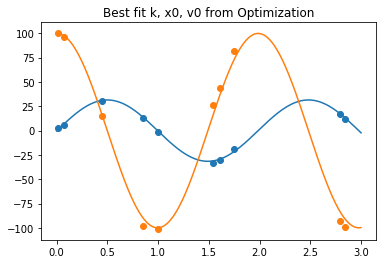

In [25]:
#plot best fit from optimization 
x, v, t = leapfrog(res.x[1], res.x[2], t_obs, phi_grad, dt_model, nmodelpoints, k=res.x[0])
t_compare = np.linspace(0, dt*nmodelpoints, 1000)
x_compare, v_compare, t_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt_model, nmodelpoints, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0')
plt.plot(t_compare, v_compare, c='C1')
plt.errorbar(t_obs, x_obs, yerr=std_noise, fmt='o', color='C0')
plt.errorbar(t_obs, v_obs, yerr=std_noise, fmt='o', color='C1')
plt.title('Best fit k, x0, v0 from Optimization')

In [26]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  

In [27]:
def nll(*args):
    return -ln_likelihood(*args)

In [28]:
grad_ln_like = grad(nll)

In [29]:
grad_ln_like(p0, data, dt_model)

[array(2161.646296586348), array(379.56214789978014), array(136.391368574384)]

In [30]:
#%%timeit
#args = (data, dt_model) 
#res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [31]:
args = (data, dt_model) 
res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [32]:
res

      fun: 11.77802836833003
 hess_inv: array([[ 0.00170221, -0.0113231 ,  0.00288454],
       [-0.0113231 ,  0.10125062, -0.05959965],
       [ 0.00288454, -0.05959965,  0.2082882 ]])
      jac: array([ -4.75025131e-06,   9.31215304e-07,   6.26311272e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([  10.03924535,   -0.30802285,  100.00996927])

Text(0.5,1,'Best fit k, x0, v0 from Optimization')

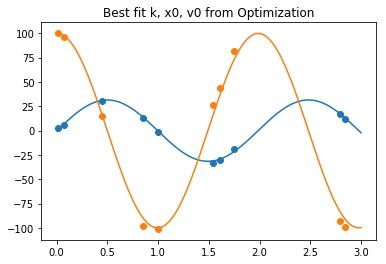

In [33]:
#plot best fit from optimization 
x, v, t = leapfrog(res.x[1], res.x[2], t_obs, phi_grad, dt_model, nmodelpoints, k=res.x[0])
x_compare, v_compare, t_compare = leapfrog(res.x[1], res.x[2], np.linspace(0, dt*nmodelpoints, 1000), phi_grad, dt_model, nmodelpoints, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0')
plt.plot(t_compare, v_compare, c='C1')
plt.errorbar(t_obs, x_obs, yerr=std_noise, fmt='o', color='C0')
plt.errorbar(t_obs, v_obs, yerr=std_noise, fmt='o', color='C1')
plt.title('Best fit k, x0, v0 from Optimization')